# LightGBM 

In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import datetime
import seaborn as sns
from sklearn.preprocessing import StandardScaler

import os
for dirname, _, filenames in os.walk('../data/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

../data/classweight_submission_Logistic4.csv
../data/ozon_4_.ipynb
../data/sample_submit.csv
../data/smoto_submission_ensemble.csv
../data/smoto_submission_lightBGM.csv
../data/smoto_submission_lightBGM_0516_2.csv
../data/smoto_submission_Logistic.csv
../data/submission_ensemble.csv
../data/submission_lightBGM.csv
../data/submission_lightBGM2.csv
../data/submission_lightBGM2_2.csv
../data/submission_lightBGM3.csv
../data/submission_Logistic.csv
../data/submission_Logistic2.csv
../data/submission_Logistic3.csv
../data/sumote_submission_lightBGM_0516.csv
../data/sumote_submission_lightBGM_0516_3.csv
../data/sumote_submission_lightBGM_0522.csv
../data/sumote_submission_lightBGM_0522_binaryerror.csv
../data/sumote_submission_lightBGM_0522_clossentropy.csv
../data/sumote_submission_lightBGM_0524.csv
../data/sumoto_submission_Logistic2.csv
../data/sumoto_submission_Logistic3.csv
../data/sumoto_submission_Logistic3_2.csv
../data/sumoto_submission_Logistic3_3.csv
../data/sumoto_submission_Logi

In [51]:
train_df = pd.read_table('../data/train.tsv', index_col='Date', parse_dates=True)
test_df = pd.read_table('../data/test.tsv', index_col='Date', parse_dates=True)
sample_sub = pd.read_csv('../data/sample_submit.csv', header=None)
print(sample_sub)

# set type label
train_df['type'] = 'train'
test_df['type'] = 'test'

# all data
all_df = pd.concat([train_df, test_df], axis=0)

         0    1
0     1267  0.0
1     1268  0.0
2     1269  0.0
3     1270  1.0
4     1271  1.0
...    ...  ...
1262  2529  1.0
1263  2530  1.0
1264  2531  0.0
1265  2532  1.0
1266  2533  0.0

[1267 rows x 2 columns]


## 特徴量前処理

In [52]:
import re
from imblearn.over_sampling import SMOTE


def eda(all_df):
    # データの追加,気温・風速の標準偏差
    #1時間ごとの気温・風速を取得
    T_data = all_df[['T0', 'T1', 'T2', 'T3', 'T4', 'T5', 'T6', 'T7', 'T8', 'T9', 'T10', 'T11', 'T12', 'T13', 'T14', 'T15', 'T16', 'T17', 'T18', 'T19', 'T20', 'T21', 'T22', 'T23']]
    WSR_data = all_df[['WSR0', 'WSR1', 'WSR2', 'WSR3', 'WSR4', 'WSR5', 'WSR6', 'WSR7', 'WSR8', 'WSR9', 'WSR10', 'WSR11', 'WSR12', 'WSR13', 'WSR14', 'WSR15', 'WSR16', 'WSR17', 'WSR18', 'WSR19', 'WSR20', 'WSR21', 'WSR22', 'WSR23']]
    # 行ごとの標準偏差を追加
    all_df['T_SD'] = T_data.std(axis=1)
    all_df['WSR_SD'] = WSR_data.std(axis=1)
    """
    # データの削除, T0~T23
    all_df = all_df.drop(columns=['T0', 'T1', 'T2', 'T3', 'T4', 'T5', 'T6', 'T7', 'T8', 'T9', 'T10', 'T11', 'T12', 'T13', 'T14', 'T15', 'T16', 'T17', 'T18', 'T19', 'T20', 'T21', 'T22', 'T23'])
    # データの削除, WSR0~WSR23
    all_df = all_df.drop(columns=['WSR0', 'WSR1', 'WSR2', 'WSR3', 'WSR4', 'WSR5', 'WSR6', 'WSR7', 'WSR8', 'WSR9', 'WSR10', 'WSR11', 'WSR12', 'WSR13', 'WSR14', 'WSR15', 'WSR16', 'WSR17', 'WSR18', 'WSR19', 'WSR20', 'WSR21', 'WSR22', 'WSR23'])
    """
    # データの削除, SLP_
    all_df = all_df.drop(columns=['SLP_'])
    return all_df


# 特徴量の削除/追加
all_df = eda(all_df)

# trainとtestに分けなおす
train_df = all_df[all_df['type'] == 'train']
test_df = all_df[all_df['type'] == 'test']
# train正解ラベル
y = train_df['OZONE']

# 学習に不要な特徴量を削除
train_df = train_df.drop(columns=['id', 'OZONE', 'type'])
test_df = test_df.drop(columns=['id', 'OZONE', 'type'])

# 欠損値を平均値で補完
train_df = train_df.fillna(train_df.mean())
test_df = test_df.fillna(test_df.mean())

# オーバーサンプリング
# SMOTEの初期化と適用
# smote = SMOTE(random_state=42)
# train_df, y = smote.fit_resample(train_df, y)

"""
# データ標準化(rightGBMのときはいらない)
scaler = StandardScaler()
train_df = pd.DataFrame(scaler.fit_transform(train_df), index = train_df.index, columns = train_df.columns)
test_df = pd.DataFrame(scaler.transform(test_df), index = test_df.index, columns = test_df.columns)
"""
print(y)
# print(f'train_df : \n{train_df}\n')
# print(f'y : \n{y}\n')
print(y.sum())

Date
1998-01-01    0.0
1998-01-02    0.0
1998-01-03    0.0
1998-01-04    0.0
1998-01-05    0.0
             ... 
2001-06-29    0.0
2001-06-30    0.0
2001-07-01    0.0
2001-07-02    0.0
2001-07-03    0.0
Name: OZONE, Length: 1267, dtype: float64
111.0


### LightGBM

In [74]:
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
import lightgbm as lgb
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report, confusion_matrix,precision_recall_curve,auc

#khold
n_splits = 5
cv = StratifiedKFold(n_splits=n_splits, random_state=0, shuffle=True)

train_acc_list = []
val_acc_list = []
models = []
lgb_results = {}   # 学習の履歴を入れる入物

# ハイパーパラメータを定義　
lgb_params = {
    "objective":"binary",     #目的：二値分類
    # "metric": "binary_error",  #評価指標 : 不正解率(1 - 正解率)
    # "metric": "binary_logloss",
    'metric': 'None',  #自作関数
    # "force_row_wise" : True,
    "seed" : 0,
    'learning_rate': 0.1,
    # 'min_data_in_leaf': 5,
    # "reg_lambda": .1,
     # "reg_alpha": .1,
    # "early_stopping_rounds": 50,
    # "verbose_eval": 200,
    # "max_depth": 5, 
    # "min_child_samples": 20,
    'verbosity': -1,
    }

def sigmoid(x):
  return 1.0 / (1.0 + np.exp(-x))

def f_pr_auc(probas_pred, y_true):
    probas_pred=sigmoid(probas_pred)
    labels=y_true.get_label()
    precision, recall, _ = precision_recall_curve(labels, probas_pred)
    score=auc(recall, precision)
    return "pr_auc", score, True

# indexをDateから普通のindexに直す(kholdが使えないため)、日付は消す
train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

# KFold で学習させる
for i ,(trn_index, val_index) in enumerate(cv.split(train_df, y)):
    
    print(f'Fold : {i}')
    X_train ,X_val = train_df.iloc[trn_index], train_df.iloc[val_index]
    y_train ,y_val = y.iloc[trn_index],y.iloc[val_index]
    
    # LigthGBM用のデータセットを定義
    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_valid = lgb.Dataset(X_val, y_val, reference=lgb_train)
    
    # 学習
    model = lgb.train(
        params = lgb_params,         # ハイパーパラメータをセット
        train_set = lgb_train,       # 訓練データを訓練用にセット
        valid_sets = [lgb_train, lgb_valid],   # 訓練データとテストデータをセット
        valid_names=['Train', 'Valid'],    # データセットの名前をそれぞれ設定
        feval=f_pr_auc,
        callbacks=[lgb.log_evaluation(period=100),lgb.early_stopping(10), lgb.record_evaluation(lgb_results)], # アウトプット
    )

    
    models.append(model)
    
    y_pred = model.predict(X_train, num_iteration=model.best_iteration)
    y_pred = np.where(y_pred>=0.07,1,0)
    train_acc = balanced_accuracy_score(
        y_train, y_pred
        )
    print(train_acc)
    
    print('===train_data===')
    print(confusion_matrix(y_train, y_pred))
    print(classification_report(y_train, y_pred))

    train_acc_list.append(train_acc)
    
    y_pred_val = model.predict(X_val, num_iteration=model.best_iteration)
    y_pred_val = np.where(y_pred_val>=0.07,1,0)
    val_acc = balanced_accuracy_score(
        y_val, y_pred_val
        )
    print(val_acc)

    print('===val_data===')
    print(confusion_matrix(y_val, y_pred_val))
    print(classification_report(y_val, y_pred_val))

    val_acc_list.append(val_acc)
    
    # score = f1_score(df["MIS_Status"], df["pred"] >= 0.5, average = "macro")
    

print('-'*10 + 'Result' +'-'*10)
print(f'Train_acc : {train_acc_list} , Ave : {np.mean(train_acc_list)}')
print(f'Valid_acc : {val_acc_list} , Ave : {np.mean(val_acc_list)}')

Fold : 0
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[35]	Train's pr_auc: 1	Valid's pr_auc: 0.710745
0.9832251082251082
===train_data===
[[893  31]
 [  0  89]]
              precision    recall  f1-score   support

         0.0       1.00      0.97      0.98       924
         1.0       0.74      1.00      0.85        89

    accuracy                           0.97      1013
   macro avg       0.87      0.98      0.92      1013
weighted avg       0.98      0.97      0.97      1013

0.8942006269592476
===val_data===
[[204  28]
 [  2  20]]
              precision    recall  f1-score   support

         0.0       0.99      0.88      0.93       232
         1.0       0.42      0.91      0.57        22

    accuracy                           0.88       254
   macro avg       0.70      0.89      0.75       254
weighted avg       0.94      0.88      0.90       254

Fold : 1
Training until validation scores don't improve for 10 rounds
Early s

### 学習履歴の表示

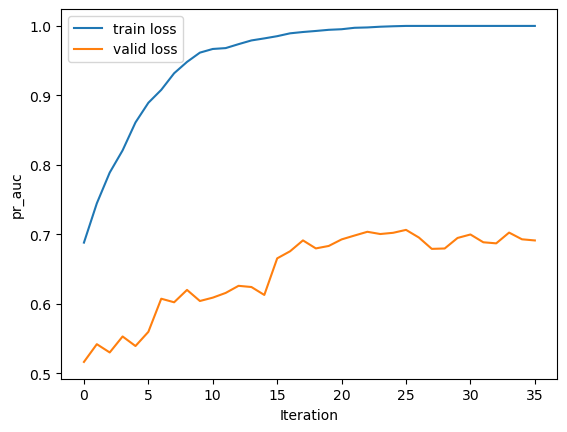

In [75]:
loss_train = lgb_results['Train']['pr_auc']
loss_valid = lgb_results['Valid']['pr_auc']   
  
fig = plt.figure()
ax1 = fig.add_subplot(111)
  
ax1.set_xlabel('Iteration')
ax1.set_ylabel('pr_auc')
 
ax1.plot(loss_train, label='train loss')
ax1.plot(loss_valid, label='valid loss')
 
plt.legend()
plt.show()

In [76]:
# モデルを用いてテストデータを予測
test_score_array = np.zeros(len(test_df))
for model in models:
    test_pred = model.predict(test_df, num_iteration=model.best_iteration)
    test_score_array += test_pred / n_splits
test_score_array = np.where(test_score_array>=0.07,1,0)

result = pd.DataFrame({"id": sample_sub.iloc[:, 0], "OZONE": test_score_array})
print(result)

test_score_array.sum()

        id  OZONE
0     1267      0
1     1268      0
2     1269      0
3     1270      0
4     1271      1
...    ...    ...
1262  2529      0
1263  2530      0
1264  2531      0
1265  2532      0
1266  2533      0

[1267 rows x 2 columns]


140

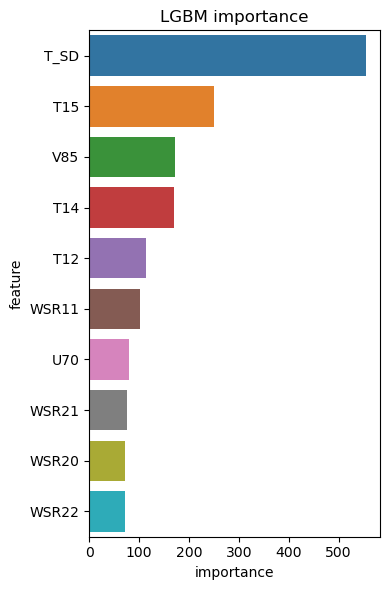

In [77]:
# 特徴量の重要度を可視化
# 特徴量重要度を保存する dataframe を用意
# https://www.sairablog.com/article/lightgbm-sklearn-kaggle-classification.html から抜粋
top_feature_num = 10
feature_importances = pd.DataFrame({
  'feature' : model.feature_name(),
  'importance': model.feature_importance(importance_type='gain'),
})

order = list(feature_importances.groupby("feature")["importance"].mean().sort_values(ascending=False).index)[:top_feature_num]

plt.figure(figsize=(4, 6))
sns.barplot(x='importance', y='feature', data=feature_importances, order=order)
plt.title('LGBM importance')
plt.tight_layout()
plt.show()

In [78]:
# Shapによる解析
# 特徴量が結果に対してどのような影響を与えたか定量的に求める(et.モデルの生成理由)

import shap

shap.initjs()
explainer = shap.Explainer(model, X_train)
shap_values = explainer(X_train, check_additivity=False)


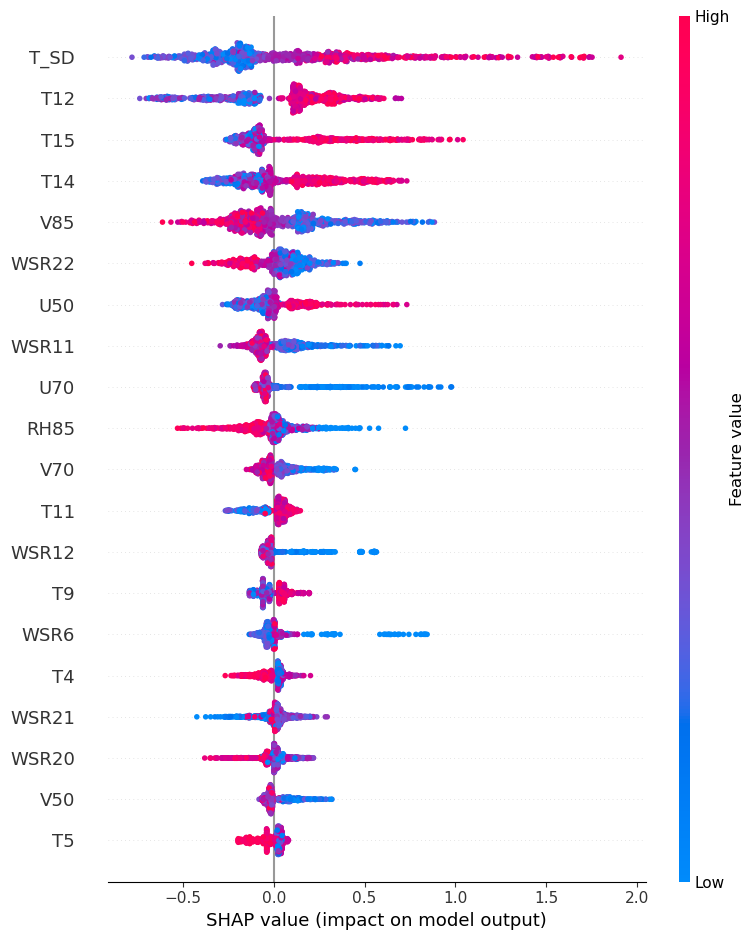

In [79]:
# summary plot
# 特徴量毎にどの程度影響を与えたか可視化(目的変数に対して、青が正の影響を、赤が負の影響を与えた事を表している)
shap.summary_plot(shap_values, X_train)

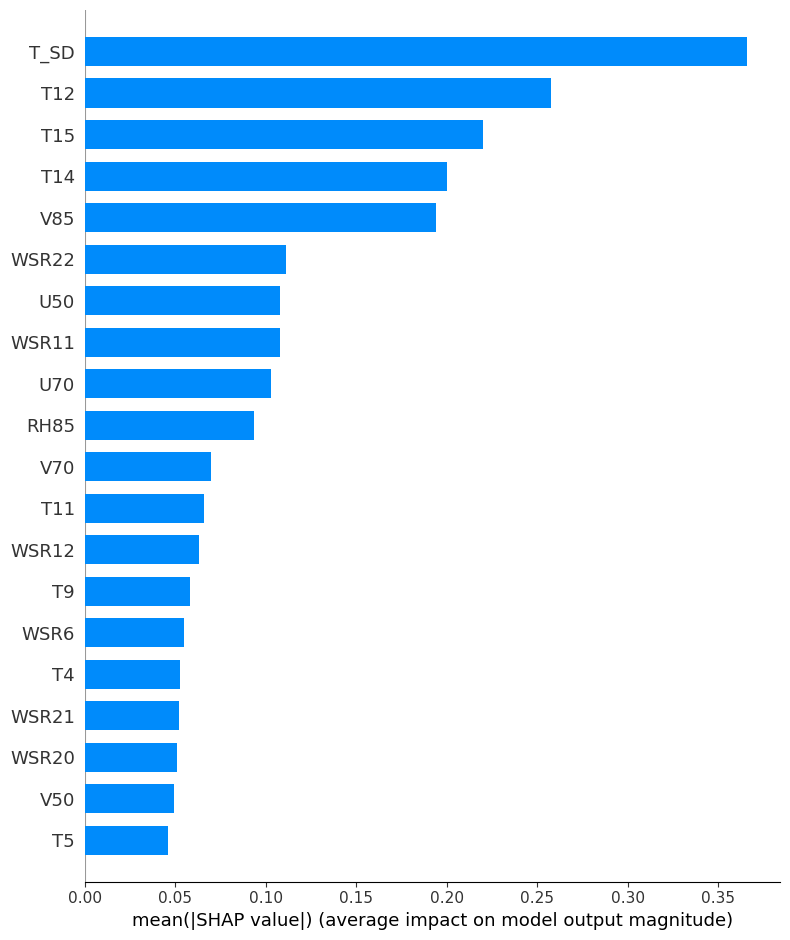

In [80]:
# 正と負のトータルとしてどのような影響を与えたか
shap.summary_plot(shap_values, X_train, plot_type="bar")

In [ ]:
# 特徴量の依存性確認
# それぞれの特徴量とSHAP値の相関関係を可視化
"""
feature_importances = pd.DataFrame({
  'feature' : model.feature_name(),
  'importance': model.feature_importance(importance_type='gain'),
})
feature_list = list(feature_importances.groupby("feature")["importance"].mean().sort_values(ascending=False).index)
for feature in feature_list:
  shap.dependence_plot(feature, shap_values.values, X_train)
  """

In [68]:
# 結果を保存
result.to_csv("../data/sumote_submission_lightBGM_0524_3.csv", index=None, header=None)